In [3]:
# Размеры матриц
original_matrix_size = 100000 * 100000
compressed_matrix_size = 100000 * 300 + 300 * 100000

# Размеры в байтах
original_bytes = original_matrix_size * 4
compressed_bytes = compressed_matrix_size * 4

# Экономия памяти в байтах
saved_bytes = original_bytes - compressed_bytes

# Перевод в гигабайты и округление
saved_gb = round(saved_bytes / (1024 ** 3))
saved_gb


37

# Сборный проект - 2

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. 

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Задачи:**

1) Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2) Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача

**План**

1. Выгрузить файлы с данными
**Предобработка**


2. Изучить общую информацию
3. Если есть пропуски, заполните их в пайплайне
**Исследовательский анализ данных**

4. Исследуем все данные из таблиц.
5. Сделаем выводы о том, как нужно подготовить данные
**Подготовка данных**

8. Подготовку данных сделаем в пайплайне

**Обучение моделей**

9. Обучим как две модели и подберем гиперпараметры:
- линейную
- дерево решений
- случайное дерево
8. Для проверки качества моделей используем метрику SMAPE. Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

**Вывод о лучшей модели**

In [1]:
! pip install phik -q
! pip install -Uq scikit-learn
! pip install shap  -q # -q убирает необязательные выводы в командах Linux

In [2]:
import sklearn
sklearn.__version__

'1.4.1.post1'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap


from scipy import stats
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, confusion_matrix,  roc_auc_score, precision_recall_curve, mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree 
from sklearn.inspection import permutation_importance

In [4]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

### Загрузка данных

In [5]:
data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [6]:
data.head(20)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
test_features.head(20)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [9]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [10]:
test_target_job_satisfaction.head(20)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


In [11]:
test_target_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Итак, мы загрузили данные, у нас есть тренировочные данные о 4000 сотрудниках, тестовыве данные о 2000 сотрудниках. Мы видим что названия столбцов и типы данных корректны, исправлять их мы не будем. Пропуски будем заполнять в пайплайне модой.

Также заметим, что в тестовых данных строки перемешаны. Нельзя будет просто вставить эти данные в модель

### Предобработка данных

Пропуски будем заполнять в пайплайне, а здесь проверим наличие полных и скрытых дубликатов

In [12]:
data.duplicated().sum()

0

In [13]:
test_features.duplicated().sum()

0

In [14]:
data['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [15]:
data['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [16]:
data['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

Дубликатов нет, но sinior написано неправильно

In [17]:
data['level'] = data['level'].replace('sinior', 'senior')

In [18]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [19]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [20]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

Здесь мы видим пропуски в виде пробелов, которые тоже обработаем в пайплайне. Также исправим sinior

In [21]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')

### Исследование данных

In [22]:
def plot_hist_box(df, column, title, xlabel, ylabel, bins=100):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1, 2, 1)
    df[column].hist(bins=bins)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
    plt.subplot(1, 2, 2)
    df[column].plot(kind='box')
    
    plt.show()
    
    
def plot_pie(df, column, title, df2, title2):
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    p = df.groupby(column)[column].count().plot(kind='pie', autopct='%1.0f%%')
    p.yaxis.set_visible(False)
    plt.title(title)
    plt.subplot(1, 2, 2)
    p = df2.groupby(column)[column].count().plot(kind='pie', autopct='%1.0f%%')
    p.yaxis.set_visible(False)
    plt.title(title2)
    plt.show()

Проведем исследовательский анализ всех признаков и тренировочной и тестовой выборки, чтобы заодно понять, насколько схожи данные

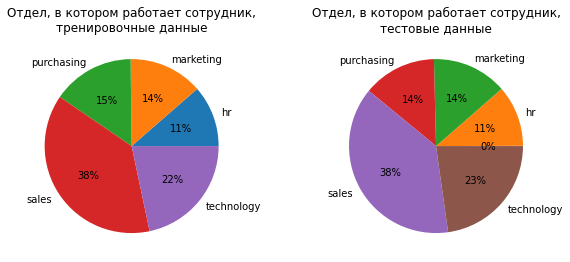

In [23]:
plot_pie(data, 'dept', 'Отдел, в котором работает сотрудник,\nтренировочные данные', test_features, 'Отдел, в котором работает сотрудник,\nтестовые данные')


Больше всего сотрудников из отдела продаж (38%). Меньше всего в HR и маркетинге.

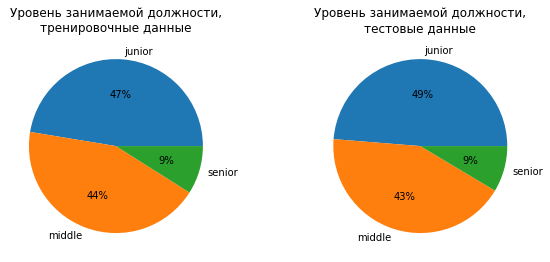

In [24]:
plot_pie(data, 'level', 'Уровень занимаемой должности,\nтренировочные данные', test_features, 'Уровень занимаемой должности,\nтестовые данные')


Одинаково много джунов и мидлов, меньше всего сотрудников уровня сеньор (9%)

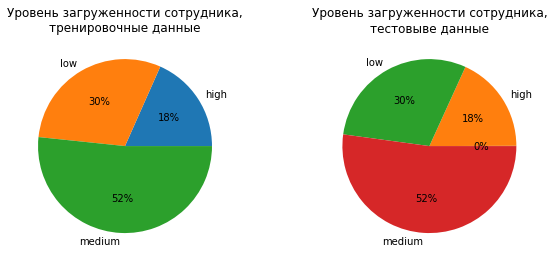

In [25]:
plot_pie(data, 'workload', 'Уровень загруженности сотрудника,\nтренировочные данные', test_features, 'Уровень загруженности сотрудника,\nтестовыве данные')


У половины сотрудников средняя загрузка, у 30% низкая, у 18% высокая

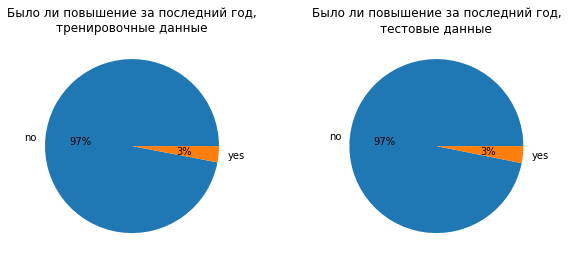

In [26]:
plot_pie(data, 'last_year_promo', 'Было ли повышение за последний год,\nтренировочные данные', test_features, 'Было ли повышение за последний год,\nтестовые данные')

Повышение в последний год получили всего 3% сотрудников

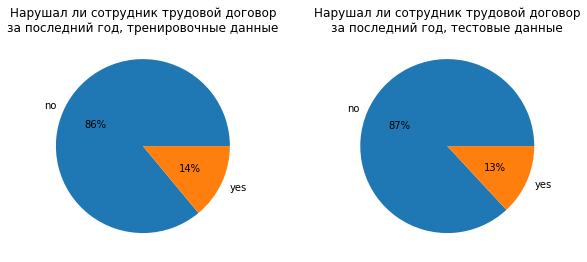

In [27]:
plot_pie(data, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор\nза последний год, тренировочные данные', test_features, 'Нарушал ли сотрудник трудовой договор\nза последний год, тестовые данные')

Трудовой договор нарушали всего 14% сотрудников

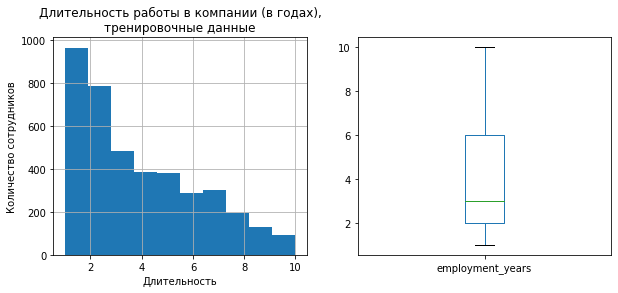

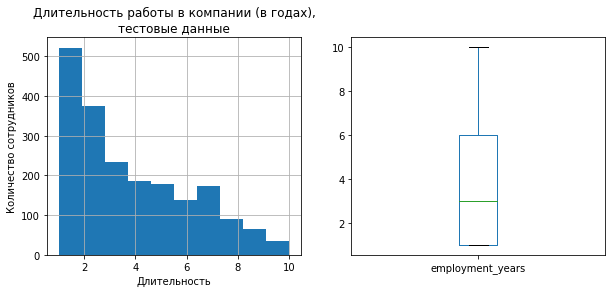

In [28]:
plot_hist_box(data, 'employment_years', 'Длительность работы в компании (в годах),\nтренировочные данные', 'Длительность', 'Количество сотрудников', 10)
plot_hist_box(test_features, 'employment_years', 'Длительность работы в компании (в годах),\nтестовые данные', 'Длительность', 'Количество сотрудников', 10)

Больше всего сотрудников работают в компании небольшое время 1-2 года. Но есть и те, кто работал до 20 лет. Медиана - 3 года. На тестовых данных она чуть выше

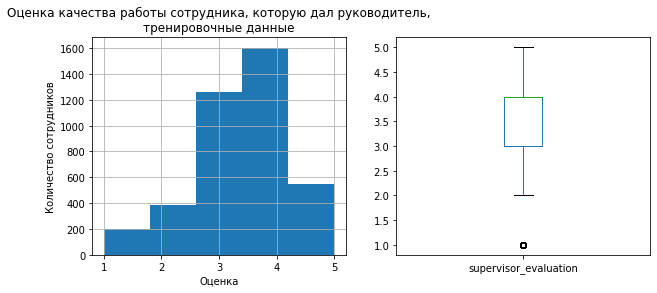

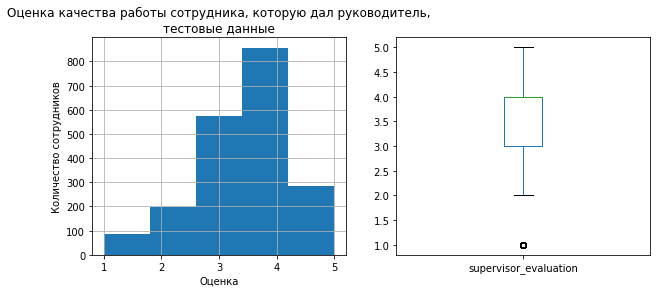

In [29]:
plot_hist_box(data, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель,\nтренировочные данные', 'Оценка', 'Количество сотрудников', 5)
plot_hist_box(test_features, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель,\nтестовые данные', 'Оценка', 'Количество сотрудников', 5)

У большинства сотрудников оценка работы 3 или 4. Оценка 1 реже всего

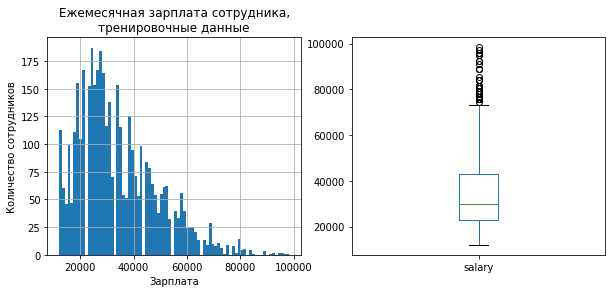

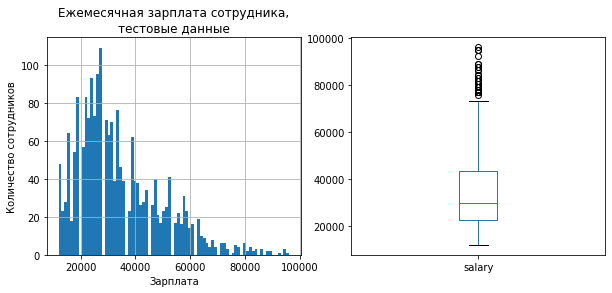

In [30]:
plot_hist_box(data, 'salary', 'Ежемесячная зарплата сотрудника,\nтренировочные данные', 'Зарплата', 'Количество сотрудников', 80)
plot_hist_box(test_features, 'salary', 'Ежемесячная зарплата сотрудника,\nтестовые данные', 'Зарплата', 'Количество сотрудников', 80)

Медианная зарплата ~30000 рублей. На графике боксплот видим много выбросов от 75 до 100 тыс рублей, но большинство сотрудников получают от 25 до 42 тыс рублей

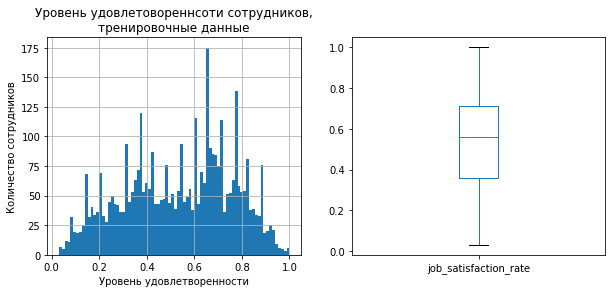

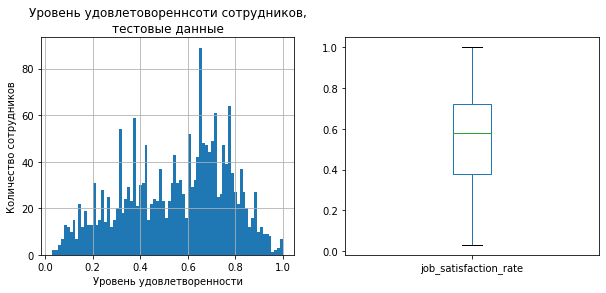

In [31]:
plot_hist_box(data, 'job_satisfaction_rate', 'Уровень удовлетовореннсоти сотрудников,\nтренировочные данные', 'Уровень удовлетворенности', 'Количество сотрудников', 80)
plot_hist_box(test_target_job_satisfaction, 'job_satisfaction_rate', 'Уровень удовлетовореннсоти сотрудников,\nтестовые данные', 'Уровень удовлетворенности', 'Количество сотрудников', 80)

Медианный уровень удовлетворенности ~0.55. Распределение бимодальное

Итак, тестовые и обучающие данные очень похожи.

Для того чтобы понять, какие признаки кореллируют, построим матрицу корелляции и диаграммы рассеяния. Исклюсим id из корелляционного анализа

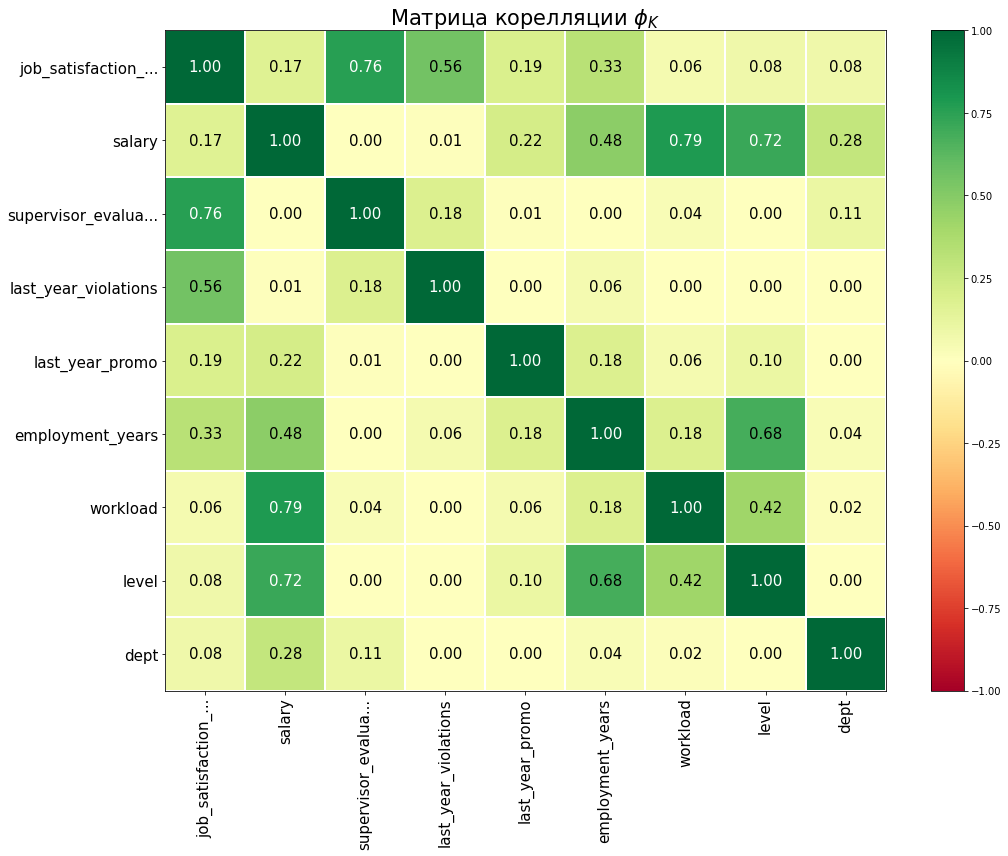

In [32]:
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = data.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица корелляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Видим что больше всего удовлетворенность работой кореллирует с оценкой работы руководителя. Меньшая корелляция с длительностью работы и с нарушениями.

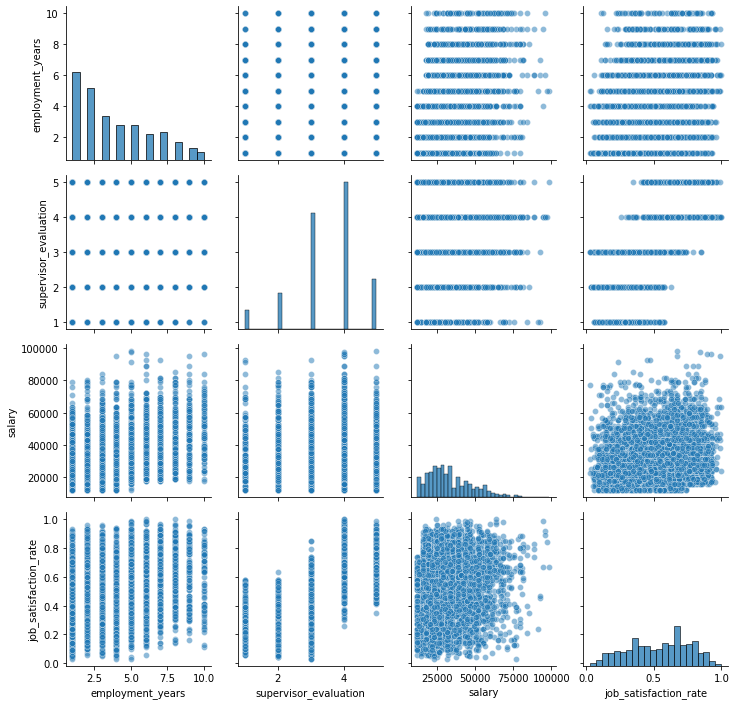

In [33]:
cols = ['dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']
g = sns.PairGrid(data[cols])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, alpha=0.5)
g.add_legend();

Что мы увидели на диаграммах рассеяния и матрице корелляции:


- Видим что больше всего удовлетворенность работой кореллирует с оценкой работы руководителя. Меньшая корелляция с длительностью работы и с нарушениями. 
- Диаграмма рассеяния уровня удовлетворенности от оценки руководителя подтвердило корелляцию. Так же здесь мы видим, что у сотрудников которык работают больше 5 лет почти нет нелувой удовлетворенности



### Подготовка данных

Создадим пайплайн для предобработки данных, заполнения пропусков, кодирования масштабирования.

In [34]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']
ord_columns = ['level', 'workload']

In [35]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 



Удалим столбец id, тк для моделирования он ничего не даст, а наоборот может дать утечку данных

In [36]:
data = data.drop(['id'], axis=1)

Проверим снова на полные дубликаты, так как они могут помешать правильному обучению модели. Удалим их

In [37]:
data.duplicated().sum()

245

In [38]:
data = data.drop_duplicates()

Разделим тренироваочную выборку на признаки и целевой

In [39]:
X_train = data.drop(['job_satisfaction_rate'], axis=1)
y_train = data['job_satisfaction_rate']

Объединим признаки тестовых данных чтобы id шли в одинаковом порядке и снова разделим на выборки

In [40]:
merged = pd.merge(test_features, test_target_job_satisfaction, on='id')
X_test = merged.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = merged['job_satisfaction_rate']

### Моделирование

**Функция для рассчета метрики SMAPE**

Для проверки качества моделей будем использовать новую метрику - SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»)

In [41]:
def SMAPE(y_test, y_perd):
    return 100/len(y_test) * np.sum(2 * np.abs(y_perd - y_test) / (np.abs(y_test) + np.abs(y_perd)))

In [42]:
score = make_scorer(SMAPE, greater_is_better=False)

Создадим итоговый пайплайн для подготовки данных и обучения подели

In [43]:
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor())
])

Воспользуемсмя рандомизированным поиском, чтобы подобрать лучшую модель и гиперпараметры.

In [44]:
RANDOM_STATE = 42

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'models__splitter': ['best', 'random'],
        'models__max_depth': [None, 5, 10, 15, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models' : [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300, 400, 500],
        'models__max_depth': [None, 10, 20, 30, 40, 50],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'models__bootstrap': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

In [45]:
randomized_search = RandomizedSearchCV(
    pipe_tree, 
    param_grid, 
    cv=5,
    scoring=score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)


Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__n_estimators': 100, 'models__min_samples_split': 5, 'models__min_samples_leaf': 1, 'models__max_depth': 40, 'models__bootstrap': True, 'models': RandomForestRegressor(random_state=42)}
Метрика лучшей модели на кросс-валидации: -13.822043884008513


Посмотрим также на параметры других моделей

In [46]:
results = randomized_search.cv_results_
for i in range(len(results['params'])):
    print("Модель: {0}".format(i+1))
    print("Метрика на кросс-валидации: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_score'][i],
          results['std_test_score'][i]))
    print("Параметры: {0}".format(results['params'][i]))
    print("")

Модель: 1
Метрика на кросс-валидации: -15.303 (std: 0.649)
Параметры: {'preprocessor__num': 'passthrough', 'models__splitter': 'best', 'models__min_samples_split': 10, 'models__min_samples_leaf': 5, 'models__max_depth': None, 'models__criterion': 'poisson', 'models': DecisionTreeRegressor(random_state=42)}

Модель: 2
Метрика на кросс-валидации: -14.986 (std: 0.652)
Параметры: {'preprocessor__num': MinMaxScaler(), 'models__n_estimators': 100, 'models__min_samples_split': 10, 'models__min_samples_leaf': 2, 'models__max_depth': 10, 'models__bootstrap': True, 'models': RandomForestRegressor(random_state=42)}

Модель: 3
Метрика на кросс-валидации: -13.857 (std: 0.733)
Параметры: {'preprocessor__num': 'passthrough', 'models__n_estimators': 100, 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_depth': None, 'models__bootstrap': True, 'models': RandomForestRegressor(random_state=42)}

Модель: 4
Метрика на кросс-валидации: -13.836 (std: 0.676)
Параметры: {'preprocesso

Теперь посмотрим на метрику модели на тестовой выборке

In [47]:
y_pred = randomized_search.predict(X_test)
smape_score = SMAPE(y_test, y_pred)
print(f'Метрика SMAPE на тестовой выборке: {smape_score}')

Метрика SMAPE на тестовой выборке: 12.263691001291193


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [48]:
if smape_score <= 15:
    print('Модель удовлетворяет критерию успеха')
else:
    print('Модель не удовлетворяет критерию успеха')  

Модель удовлетворяет критерию успеха


### Вывод

Итак, здесь у нас стояла задача регресии. 

На этапе изучения данных мы выяснили, с какими признаками кореллирует целевой. Мы избавились от id, а затем убрали дубликаты. 

Подготовку данных и моделирование мы провели с помощью пайплайна. Мы использовали 2 кодировщика, с помощью рандомизированного поиска подобрали лучшую модель, ее параметры и скалер.

Мы использовали кастомную метрику - SMAPE(симметричный средний процент отклонения). Рандомизированный поиск определил, что лучше всего себя показала модель RandomForestRegressor. Метрика на тестовой выборке - 12.26

## Задача: предсказание увольнения сотрудника из компании

Данные те же, но целевой признак другой - увольнение сотрудника из компании

**План**

1. Выгрузить файлы с данными
**Предобработка**


2. Изучить общую информацию
3. Если есть пропуски, заполните их в пайплайне
**Исследовательский анализ данных**

4. Исследуем все данные из таблиц.
5. Составим портрет «уволившегося сотрудника»
6. Проверим утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник
**Подготовка данных**

8. Подготовку данных сделаем в пайплайне

**Обучение моделей**

9. Обучим три модели и подберем гиперпараметры:
- логистическая регрессия
- дерево решений
- knn
8. С помощью рандомизированного поиска, использую метрику roc-auc определить лучшую модель

**Вывод о лучшей модели**

### Загрузка данных

In [49]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [50]:
train_quit.head(20)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [51]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [52]:
test_features.head(20)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [53]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [54]:
test_target_quit.head(20)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


In [55]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Итак, мы изучили новые данные, видим что целевой признак представлен как да/нет (сотрудник уволился или нет). Пропуски есть только в признаках тестовой выборки

### Предобработка данных

In [56]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [57]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [58]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

Так же исправим sinior на senior

In [59]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

In [60]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [61]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [62]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Пропуски будем заполнять в пайплайне

### Исследование данных

Посмотрим на распределение данных, оценим схожесть с предыдущей выборкой. Построим круговые диаграммы для категориальных признаков и гистограммы и боксплоты для количественных

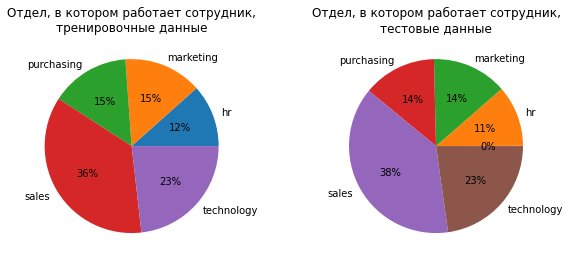

In [63]:
plot_pie(train_quit, 'dept', 'Отдел, в котором работает сотрудник,\nтренировочные данные', test_features, 'Отдел, в котором работает сотрудник,\nтестовые данные')


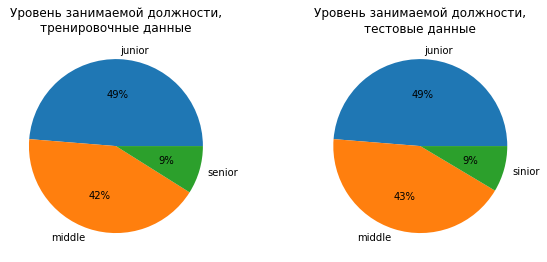

In [64]:
plot_pie(train_quit, 'level', 'Уровень занимаемой должности,\nтренировочные данные', test_features, 'Уровень занимаемой должности,\nтестовые данные')


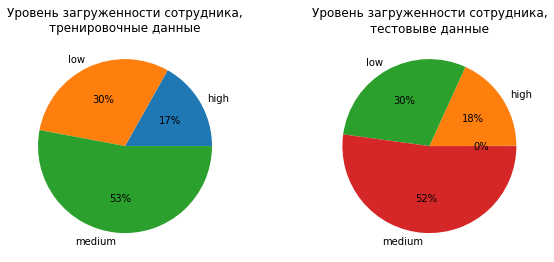

In [65]:
plot_pie(train_quit, 'workload', 'Уровень загруженности сотрудника,\nтренировочные данные', test_features, 'Уровень загруженности сотрудника,\nтестовыве данные')


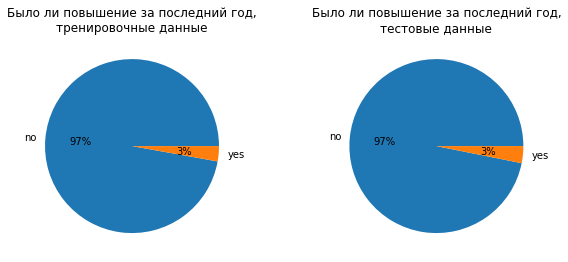

In [66]:
plot_pie(train_quit, 'last_year_promo', 'Было ли повышение за последний год,\nтренировочные данные', test_features, 'Было ли повышение за последний год,\nтестовые данные')

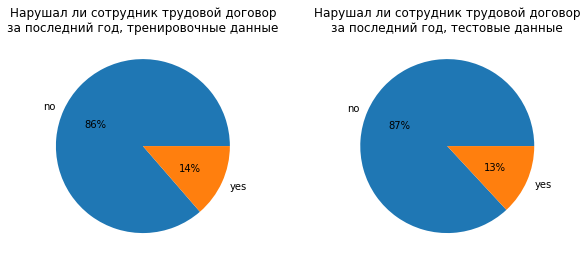

In [67]:
plot_pie(train_quit, 'last_year_violations', 'Нарушал ли сотрудник трудовой договор\nза последний год, тренировочные данные', test_features, 'Нарушал ли сотрудник трудовой договор\nза последний год, тестовые данные')

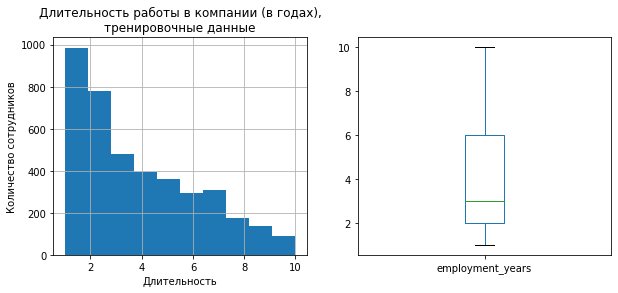

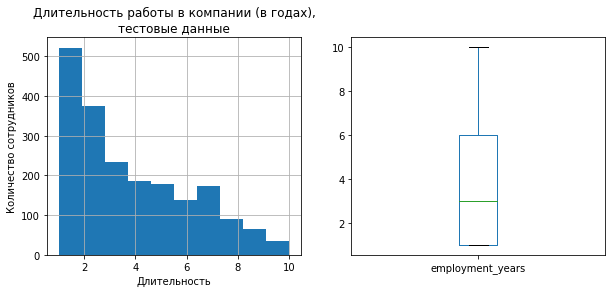

In [68]:
plot_hist_box(train_quit, 'employment_years', 'Длительность работы в компании (в годах),\nтренировочные данные', 'Длительность', 'Количество сотрудников', 10)
plot_hist_box(test_features, 'employment_years', 'Длительность работы в компании (в годах),\nтестовые данные', 'Длительность', 'Количество сотрудников', 10)

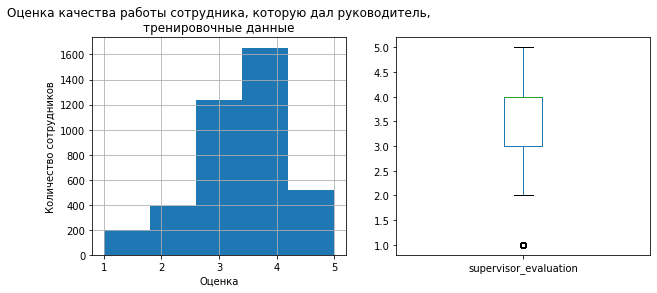

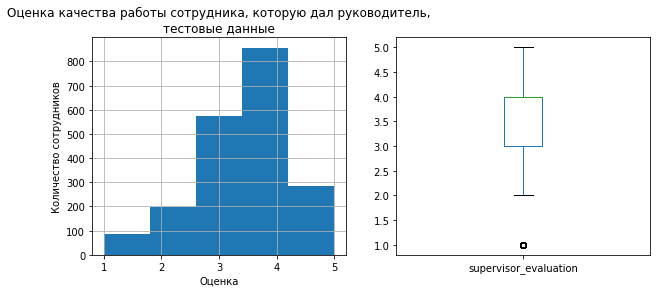

In [69]:
plot_hist_box(train_quit, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель,\nтренировочные данные', 'Оценка', 'Количество сотрудников', 5)
plot_hist_box(test_features, 'supervisor_evaluation', 'Оценка качества работы сотрудника, которую дал руководитель,\nтестовые данные', 'Оценка', 'Количество сотрудников', 5)

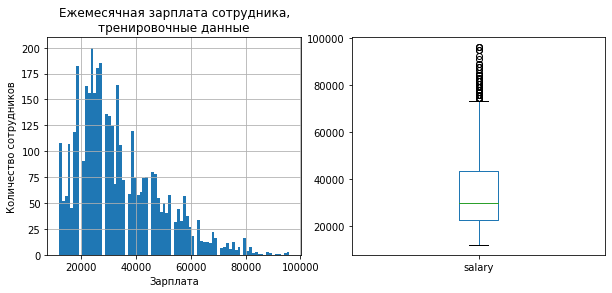

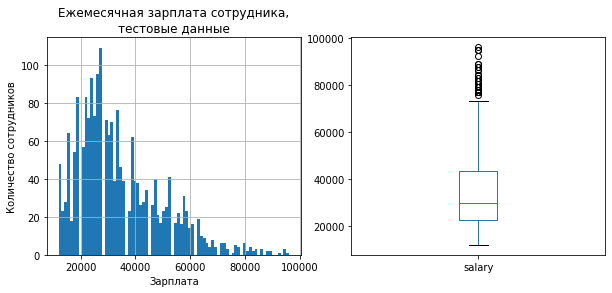

In [70]:
plot_hist_box(train_quit, 'salary', 'Ежемесячная зарплата сотрудника,\nтренировочные данные', 'Зарплата', 'Количество сотрудников', 80)
plot_hist_box(test_features, 'salary', 'Ежемесячная зарплата сотрудника,\nтестовые данные', 'Зарплата', 'Количество сотрудников', 80)

Мы видим, что данные очень похоже на те, что мы изучали для предыдущей задачи. Есть совсем небольшие различия. Также снова отмечаем схожесть тренировочных и тестовых данных, различия минимальны

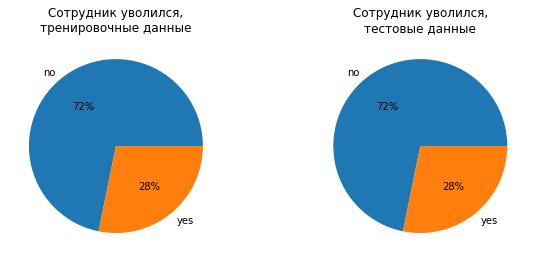

In [71]:
plot_pie(train_quit, 'quit', 'Сотрудник уволился,\nтренировочные данные', test_target_quit, 'Сотрудник уволился,\nтестовые данные' )

Уволилась четверть сотрудников

Посмотрим на матрицу корелляции

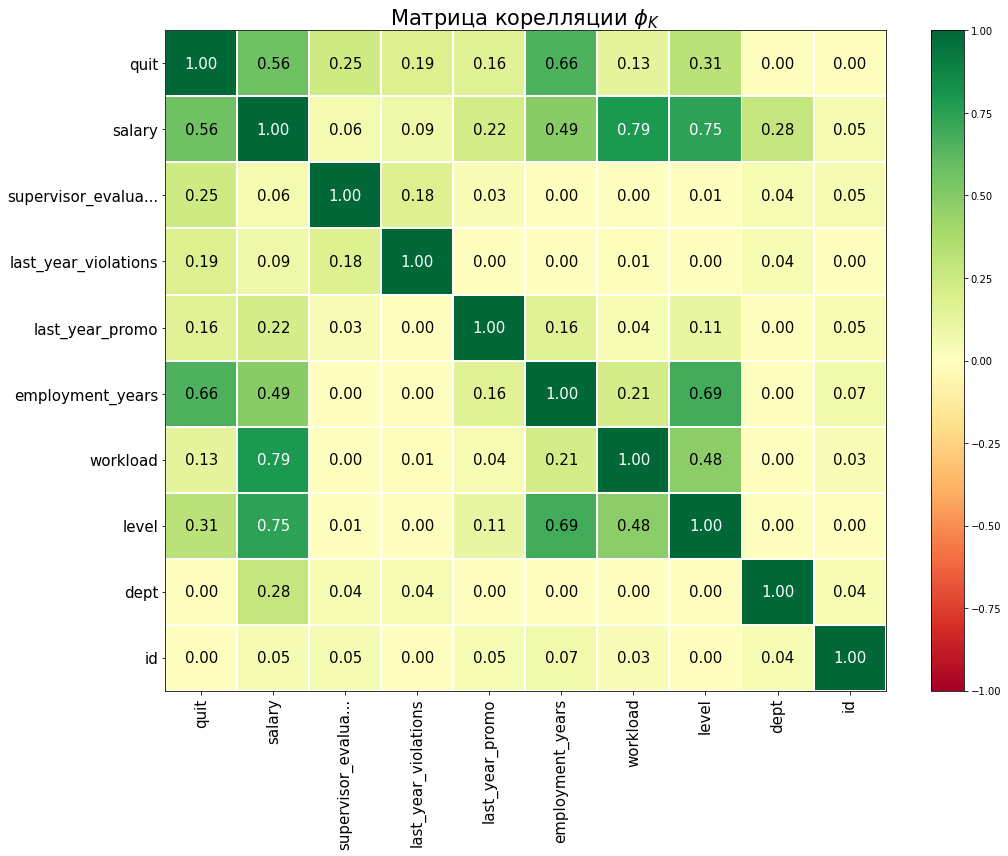

In [72]:
interval_cols = ['id', 'employment_years', 'supervisor_evaluation', 'salary']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = train_quit.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица корелляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Видим что отдел совсем не влияет на увольнение, не будем брать его в модель

**Составим портрет уволившегося сотрудника.**

Сначала посмотрим на долю уволившихся в зависимости от отдела, загрузки, уровня

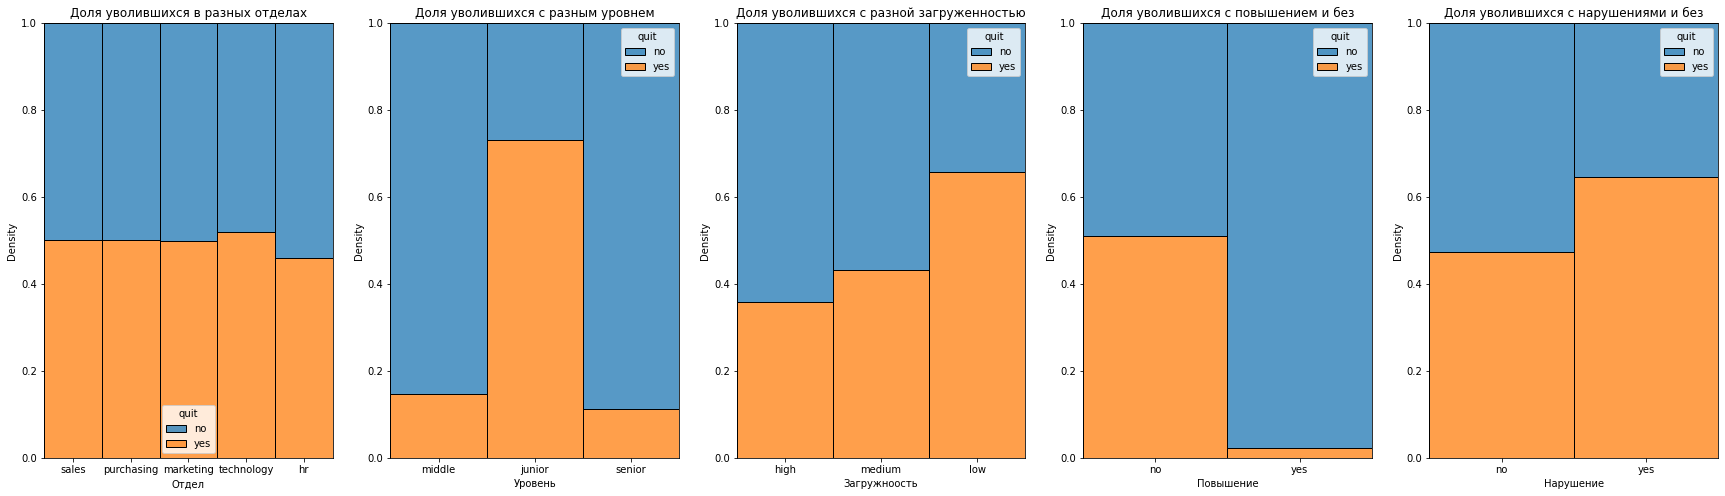

In [73]:
fig, axes = plt.subplots(1, 5, figsize=(30, 8))
i = 0
for col in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    sns.histplot(data=train_quit, x=col, hue='quit', ax=axes[i], multiple='fill', stat='density', common_norm=False)
    i += 1
    
axes[0].set_xlabel('Отдел')
axes[0].set_title('Доля уволившихся в разных отделах')
axes[1].set_xlabel('Уровень')
axes[1].set_title('Доля уволившихся с разным уровнем')
axes[2].set_xlabel('Загружноость')
axes[2].set_title('Доля уволившихся с разной загруженностью')
axes[3].set_xlabel('Повышение')
axes[3].set_title('Доля уволившихся с повышением и без')
axes[4].set_xlabel('Нарушение')
axes[4].set_title('Доля уволившихся с нарушениями и без');

Во всех отделах почти одинаковая доля увольнений, чаше всего увольняются джуны, чем меньше загруженность, тем больше увольнений, сотрудники, которых повывсили почти не увольняются, сотрудники с нарушениями увольняются чаще 

Также посмотрим на диаграммы рассеяния с разбивкой по увольнению

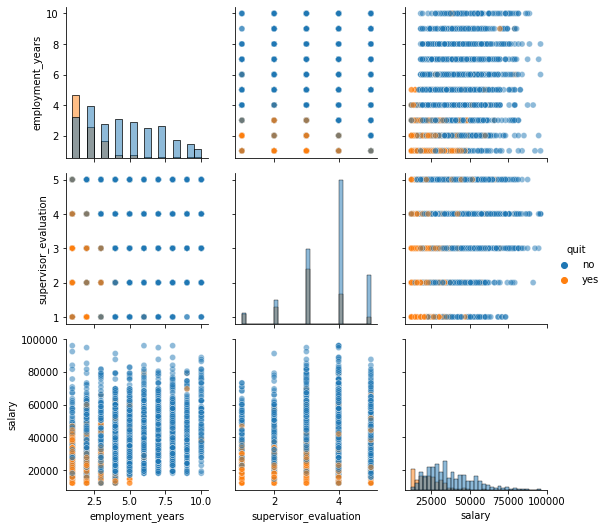

In [74]:
cols = ['employment_years', 'supervisor_evaluation', 'salary', 'quit']
g = sns.PairGrid(train_quit[cols], hue="quit")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, alpha=0.5)
g.add_legend()

Отчетливо видно, что увольняются сотрудники с меньшей зарплатой, с меньшей длительностью работы. Так же видно, но не так отчетливо, что сотрудники с высокой оценокой увольняются меньше. 

Итак, теперь мы можем составить портрет уволившегося человека:
- junior
- с низкой загрузкой
- в последний год его не повышали
- в последний год имело место нарушение трудового кодекса
- длительность работы в компании до 3-4 лет
- зарплата ниже 30000
- невысокая оценка супервизора

Проверим утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. 
Возьмем тестовые целевые данные, соединим их, чтобы у нас был и уровень удовлетворенности и факт увольнения

In [75]:
merged_data = pd.merge(test_target_job_satisfaction, test_target_quit, on='id')
merged_data.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

In [76]:
quit_yes = merged_data[merged_data['quit']=='yes']['job_satisfaction_rate']
quit_no = merged_data[merged_data['quit']=='no']['job_satisfaction_rate']


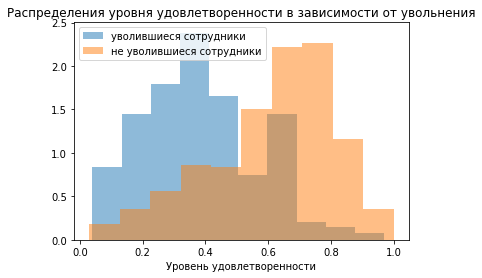

In [77]:
plt.hist(quit_yes, alpha=0.5, label='уволившиеся сотрудники', density=True)
plt.hist(quit_no, alpha=0.5, label='не уволившиеся сотрудники', density=True)
plt.legend(loc='upper left')
plt.title('Распределения уровня удовлетворенности в зависимости от увольнения')
plt.xlabel('Уровень удовлетворенности')
plt.show()

Итак, на гистограмме мы видим, что действительно, если у сотрудника уровень удовлетворенности ниже 0.5, то такие чаще увольняются. А у сотрудников с уровнем удовлетворенности 0.5-0.7 увольнения случаются в 1.5-2 раза реже, а у тех у кого он больше 0.7, увольнений почти нет

### Добавление нового входного признака

Итак, мы увидели что децствительно, уровень удовлетворенности влияет на увольнение сотрудника. Добавим job_satisfaction_rate, предсказанный моделью, к входным признакам 

In [78]:
train_quit['job_satisfaction_rate'] = randomized_search.predict(train_quit.drop(['quit', 'id'], axis=1))

In [79]:
test_features['job_satisfaction_rate'] = randomized_search.predict(test_features.drop(['id'], axis=1))

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Подготовка данных

Проведем аналогичную подготовку данных

Удалим столбец id, тк для моделирования он ничего не даст, а наоборот может дать утечку данных

In [80]:
train_quit = train_quit.drop(['id'], axis=1)

Проверим снова на полные дубликаты, так как они могут помешать правильному обучению модели. Удалим их

In [81]:
train_quit.duplicated().sum()

1413

In [82]:
train_quit = train_quit.drop_duplicates()

Подготовим данные

In [83]:
X_train = train_quit.drop(['dept', 'quit'], axis=1)
y_train = train_quit['quit']

In [84]:
merged = pd.merge(test_features, test_target_quit, on='id')
X_test = merged.drop(['dept', 'id', 'quit'], axis=1)
y_test = merged['quit']



Напишем пайплайн для подготовки данных

In [85]:
ohe_columns = ['last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
ord_columns = ['level', 'workload']
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 



### Моделирование

Создадим финальный пайплайн

In [86]:

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

Подбирать лучшую модель и параметры будем с помощью рандомизированного поиска

In [87]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            class_weight='balanced',
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Также взглянем на рузельтаты и параметры других моделей

In [89]:
results = randomized_search.cv_results_
for i in range(len(results['params'])):
    print("Модель: {0}".format(i+1))
    print("Метрика на кросс-валидации: {0:.3f} (std: {1:.3f})".format(
          results['mean_test_score'][i],
          results['std_test_score'][i]))
    print("Параметры: {0}".format(results['params'][i]))
    print("")

Модель: 1
Метрика на кросс-валидации: 0.885 (std: 0.012)
Параметры: {'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 3, 'models': DecisionTreeClassifier(class_weight='balanced', random_state=42)}

Модель: 2
Метрика на кросс-валидации: 0.823 (std: 0.019)
Параметры: {'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(class_weight='balanced', random_state=42)}

Модель: 3
Метрика на кросс-валидации: 0.890 (std: 0.016)
Параметры: {'preprocessor__num': 'passthrough', 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(class_weight='balanced', random_state=42)}

Модель: 4
Метрика на кросс-валидации: 0.845 (std: 0.010)
Параметры: {'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(class_weight='balanced', random_state=42)}

Модель: 5
Метрика на кросс-валидации: 0.849 (std: 0.013)
Параме

In [90]:
y_test_binary = (y_test == 'yes').astype(int)
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
rocauc_score = roc_auc_score(y_test_binary, y_pred_proba)
print(f'Метрика ROC-AUC на тестовой выборке: {rocauc_score}')

Метрика ROC-AUC на тестовой выборке: 0.9123519577628953


In [91]:
if rocauc_score >= 0.91:
    print('Модель удовлетворяет критерию успеха')
else:
    print('Модель не удовлетворяет критерию успеха')  

Модель удовлетворяет критерию успеха


Посмотрим на важность признаков лучшей модели с помощью permutation importance

Text(0.5, 0, 'Важность перестановки')

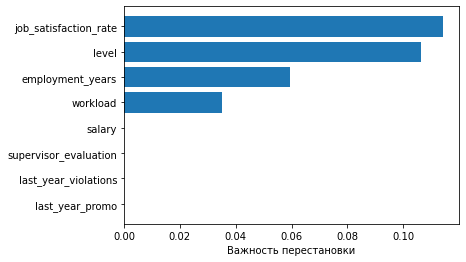

In [92]:
best_model = randomized_search.best_estimator_

perm_importance = permutation_importance(best_model, X_test, y_test)


feature_names = X_test.columns
features = np.array(feature_names)


sorted_idx = perm_importance.importances_mean.argsort()


plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Важность перестановки")


Модель посчитала уровень сотрудника и уровень удовлетворенности самыми важными признаками. Зарплата, оценка руководителя, нарушения и повышения оказались для нее неважны

### Вывод

Перед нами стояла задача классификации. Мы проанализировали признаки. Выяснили, что уровень удовлетворенности кореллирует с увольнением сотрудника, добавили этот признак, предсказанный предыдущей моделью в датафрейм и модель. Также мы не брали отдел, в котором работает сотрудник, потому что график и коэффициент показали нам, что связи нет.

Подготовку данных и моделирование мы провели с помощью пайплайна. Мы использовали 2 кодировщика, с помощью рандомизированного поиска подобрали лучшую модель, ее параметры и скалер.

Использовали метрику roc-auc, тк она подходит для нашей задачи классификации (она хорошо подходит для бинарной классификкации несбалансированной выборки. Также roc-auc учитывает вероятности, предсказанные моделью, а не просто окончательные предсказания классов. Еще roc-auc интерпретируемая - деальная модель покажет значение близкое к 1, а случайная 0.5). На тестовой выборке получили значение метрики - 0.91.

## Общий вывод

Итак, мы решили 2 необходимых задачи по регрессии и классификации для предсказания уровня удовлетворенности и увольнения сотрудника. 

**1 задача**

1) Предобработка данных
- мы проверили наличие дубликатов и скрытых дубликатов.

2) Исследование данных
- изучили все количественные и категориальные признаки, их распределения. 
- провели корелляционный анализ. Что узнали:
    - Видим что больше всего удовлетворенность работой кореллирует с оценкой работы руководителя. Меньшая корелляция с длительностью работы и с нарушениями. С id нулевая корелляция.
    - Диаграмма рассеяния уровня удовлетворенности от оценки руководителя подтвердило корелляцию. Так же здесь мы видим, что у сотрудников которык работают больше 5 лет почти нет нелувой удовлетворенности
    
3) Выполнили подготовку данных в пайплайне. Использовали 2 кодировщика, скалер, заполнение пропусков также выполнено в пайплайне. Удалили столбец с id, затем снова проверили и удалили дубликаты.

4) Провели моделирование в пайплайне с использованием рандомизированного поиска для подбора скалера, модели, гиперпараметров моделей:
- линейная регрессия
- дерево решений
- случайное дерево

Мы использовали кастомную метрику - SMAPE(симметричный средний процент отклонения). Рандомизированный поиск определил, что лучше всего себя показала модель Дерево решений. Метрика на тестовой выборке - 12.26


**2 задача** 

1) Провели аналогичную предобработку данных

2) Провели исследование данных, поняли, что они почти не отличаются от предыдущих. Также провели корелляционный анализ. Кроме этого:

    2.1) составили портрет уволившегося сотрудника:
        - junior
        - с низкой загрузкой
        - в последний год его не повышали
        - в последний год имело место нарушение трудового кодекса
        - длительность работы в компании до 3-4 лет
        - зарплата ниже 30000
        - невысокая оценка супервизора
    2.2) Удостоверились во взаимосвязи уровня удовлетворенности и увольнения:
        - На гистограмме мы видим, что действительно, если у сотрудника уровень удовлетворенности ниже 0.5, то такие чаще увольняются. А у сотрудников с уровнем удовлетворенности 0.5-0.7 увольнения случаются в разы реже, а у тех у кого он больше 0.7, увольнений почти нет
        
3) Добавили входной признак "удовлетворенность работой, так как поняли, что он влияет на увольнение

4) Подготовили данные, аналогично первой задаче

4) Провели моделирование в пайплайне с использованием рандомизированного поиска для подбора скалера, модели, гиперпараметров моделей:
- логистическая регрессия
- дерево решений
- knn

Использовали метрику roc-auc, тк она подходит для нашей задачи классификации (она хорошо подходит для бинарной классификкации несбалансированной выборки. Также roc-auc учитывает вероятности, предсказанные моделью, а не просто окончательные предсказания классов. Еще roc-auc интерпретируемая - деальная модель покажет значение близкое к 1, а случайная 0.5). На тестовой выборке получили значение метрики - 0.91.